# Raspberry Pi Camera Capture of Rubik's Cube State

First we import the libraries we need related to the Camera and image and Machine Learning libraries

In [1]:
from picamera import PiCamera
from picamera.color import Color

from gpiozero import LED

import os
from time import sleep

# import a bunch of stuff that we'll use to manipulate our images...
from skimage.io import imread
#from skimage import filter
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import block_reduce
import numpy as np

from sklearn.cluster import KMeans
import pandas as pd

import kociemba

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
# Import GPIO Libraries
import RPi.GPIO as GPIO
import time


In [5]:
GPIO.cleanup()

In [6]:
# Set up output pins for the two servo motors
GPIO.setmode(GPIO.BCM)
GPIO.setup(18, GPIO.OUT)
GPIO.setup(19, GPIO.OUT)


In [7]:
# A class to extend the PWM object to be a bit smarter
class Servo(GPIO.PWM):
    """ Smarter PWM interface to servos.  This adds a set_position method and keeps
        the state of the current position
    """
    def __init__(self, pin_number, freq, start_angle, begin_duty_cycle=2.5, 
                 end_duty_cycle=12.5, sweep_angle=120.0):
        super(Servo, self).__init__(pin_number, freq)
        
        self.angle = start_angle
        self.servo_slope = (sweep_angle)/(end_duty_cycle-begin_duty_cycle)
        self.servo_intercept = -(self.servo_slope)*begin_duty_cycle
        duty_cycle = self._map_angle_to_duty_cycle(start_angle)
        self.start(duty_cycle)
        
    def set_position(self, angle, steps=10, delay=0.1):
        
        for step in np.linspace(self.angle, angle, steps):
            duty_cycle = self._map_angle_to_duty_cycle(step)
            self.ChangeDutyCycle(duty_cycle)
            #print "setting motor to duty cycle: %s" % duty_cycle
            time.sleep(delay)
        self.angle = angle
        
    def _map_angle_to_duty_cycle(self, angle):
        return (angle-self.servo_intercept)/self.servo_slope
    
    

In [182]:
# Some initial settings which seem to work for my build
start_angle = 22
hold_angle = 42
push_angle = 60
angle_0 = 3
angle_90 = angle_0+65
roll_map = [4, 0, 2, 1, 3, 5]
rotate_map = [0, 2, 4, 3, 5, 1]
unrotate_map = [0, 5, 1, 3, 2, 4]

In [385]:
def roll_cube(servo_obj, orientation):
    servo_obj.set_position(push_angle, delay=0.06)
    servo_obj.set_position(start_angle)
    orientation = orientation[roll_map]
    return orientation
    
def rotate_cube(servo_obj, orientation):
    servo_obj.set_position(angle_90-7)
    orientation = orientation[rotate_map]
    return orientation
    
def unrotate_cube(servo_obj, orientation):
    servo_obj.set_position(angle_0)
    orientation = orientation[unrotate_map]
    return orientation
    
def hold_cube(servo_obj):
    servo_obj.set_position(hold_angle)
    
def return_cube(servo_obj):
    servo_obj.set_position(start_angle)
    
def rotate_side(servo_roll, servo_side, orientation):
    hold_cube(servo_roll)
    servo_side.set_position(angle_90, delay=0.1)
    return_cube(servo_roll)
    servo_side.set_position(angle_0, delay=0.06)
    orientation = orientation[unrotate_map]
    return orientation

def counter_rotate_side(servo_roll, servo_side, orientation):
    servo_side.set_position(angle_90-5.0, delay=0.06)
    hold_cube(servo_roll)
    servo_side.set_position(angle_0, delay=0.1)
    return_cube(servo_roll)
    orientation = orientation[rotate_map]
    return orientation

In [10]:
# Initialize the two servos
servo_roll = Servo(18, 50, start_angle)
servo_side = Servo(19, 50, angle_0)

In [11]:
# 'Full' servo range of motion for spin
servo_side.set_position(0)
servo_side.set_position(110)

In [465]:
# A little "wake up" movement from our servos to get them settled.
servo_side.set_position(angle_0)
servo_side.set_position(angle_90)
servo_side.set_position(angle_0)
servo_roll.set_position(hold_angle)
servo_roll.set_position(start_angle)

In [13]:
# Initialize light
led = LED(17)

# Begin scan of cube faces

In [466]:
face_order = np.array(['U', 'R', 'F', 'D', 'L', 'B'])
orientation = face_order.copy()


In [467]:
camera = PiCamera()

In [468]:
camera.resolution = (120, 120)

camera.hflip = False
camera.vflip = False
camera.brightness = 50 # the default is 50, but you can set it to whatever.

How about some text on the image.

In [469]:
camera.annotate_foreground = Color(1.0,1.0,0.5)

camera.annotate_text = ""
camera.annotate_text_size = 36

In [470]:
# Turn on the LED
led.on()

In [471]:
camera.start_preview()
sleep(1)
camera.capture('./img/cubeU.jpg')
camera.stop_preview()

In [472]:
# Move cube to show left side with down side at base of camera
orientation = roll_cube(servo_roll, orientation)
orientation = rotate_cube(servo_side, orientation)

In [473]:
camera.start_preview()
sleep(1)
camera.capture('./img/cubeL.jpg')
camera.stop_preview()

In [474]:
orientation = roll_cube(servo_roll, orientation)

In [475]:
camera.start_preview()
sleep(1)
camera.capture('./img/cubeB.jpg')
camera.stop_preview()

In [476]:
orientation = roll_cube(servo_roll, orientation)

In [477]:
camera.start_preview()
sleep(1)
camera.capture('./img/cubeR.jpg')
camera.stop_preview()

In [478]:
orientation = roll_cube(servo_roll, orientation)

In [479]:
camera.start_preview()
sleep(1)
camera.capture('./img/cubeF.jpg')
camera.stop_preview()

In [480]:
orientation = unrotate_cube(servo_side, orientation)
orientation = roll_cube(servo_roll, orientation)
orientation = rotate_cube(servo_side, orientation)

In [481]:
camera.start_preview()
sleep(1)
camera.capture('./img/cubeD.jpg')
camera.stop_preview()

In [482]:
orientation = unrotate_cube(servo_side, orientation)

In [483]:
led.off()

In [484]:
camera.close()

In [485]:
orientation

array(['D', 'F', 'R', 'U', 'B', 'L'],
      dtype='|S1')

## Now process the images...

In [486]:
face_images = {}
face_images_out = []
squares = {}
masks = {}  # for QA

In [487]:
for face in face_order:
    # read and cache images in dict
    face_images[face] = (imread('./img/cube%s.jpg' % face))

    img = face_images[face]
    mask = np.empty(img.shape[:2], dtype=np.bool)
    mask[::]=False
    row_coords = [(25, 30), (50, 55), (75, 80)]
    col_coords = [(38, 43), (65, 70), (95, 100)]
    squares[face] = np.zeros((3, 3, 3))
    row = 0
    # extract average RGB values from approximate square centers
    for i in row_coords:
        col = 0
        for j in col_coords:
            mask[i[0]:i[1], j[0]:j[1]] = True
            squares[face][row, col] = (np.average(img[i[0]:i[1], j[0]:j[1], 0]),
                                 np.average(img[i[0]:i[1], j[0]:j[1], 1]),
                                 np.average(img[i[0]:i[1], j[0]:j[1], 2]))
            col+=1
        row+=1
    # to show last image alignment
    masks[face] = mark_boundaries(img, mask)

(-0.5, 119.5, 119.5, -0.5)

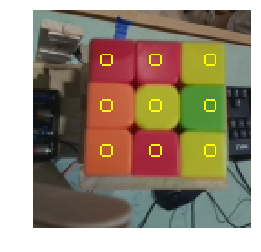

In [488]:
fig_mask = plt.figure()
ax = fig_mask.add_subplot(1,1,1)
ax.imshow(masks['D'])
plt.axis("off")

In [489]:
square_list = []
for face in face_order:
    for x in range(3):
        for y in range(3):
            r, g, b = squares[face][x,y]
            square_list.append([face, x, y, r, g, b])

columns = ['face', 'x', 'y', 'r', 'g', 'b']
square_frame = pd.DataFrame(square_list, columns=columns)

In [490]:
square_frame.head(10)

,face,x,y,r,g,b
0,U,0,0,45.28,121.20,160.16
1,U,0,1,69.80,143.20,175.60
2,U,0,2,200.08,103.12,66.40
3,U,1,0,50.00,128.84,163.12
4,U,1,1,177.60,179.20,181.00
5,U,1,2,79.08,150.36,53.52
6,U,2,0,191.48,89.32,50.20
7,U,2,1,63.56,140.52,40.44
8,U,2,2,164.16,173.20,32.88
9,R,0,0,66.20,136.68,50.20


In [491]:
X = square_frame[['r', 'g', 'b']]

In [492]:
km = KMeans(n_clusters=6, random_state=123)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [493]:
km.cluster_centers_

array([[  70.55555556,  140.91555556,   49.23555556],
       [ 192.68444444,   95.65333333,   60.81777778],
       [  54.22666667,  132.56      ,  168.35111111],
       [ 168.30222222,  170.8       ,  174.48      ],
       [ 165.39555556,  168.77333333,   44.45777778],
       [ 163.61777778,   48.80444444,   69.80888889]])

In [494]:
palette = np.zeros((100,600,3))
#print list(reversed([int(x) for x in km.cluster_centers_[0]]))
palette[0:99,0:99] = list(([int(x) for x in km.cluster_centers_[0]]))
palette[0:99,100:199] = list(([int(x) for x in km.cluster_centers_[1]]))
palette[0:99,200:299] = list(([int(x) for x in km.cluster_centers_[2]]))
palette[0:99,300:399] = list(([int(x) for x in km.cluster_centers_[3]]))
palette[0:99,400:499] = list(([int(x) for x in km.cluster_centers_[4]]))
palette[0:99,500:599] = list(([int(x) for x in km.cluster_centers_[5]]))

In [495]:
centers_list = []
center_rgb = square_frame[(square_frame['x']==1) & (square_frame['y']==1)]
print center_rgb

   face  x  y       r       g       b
4     U  1  1  177.60  179.20  181.00
13    R  1  1  173.24   55.00   79.12
22    F  1  1   71.68  144.48   56.36
31    D  1  1  169.40  171.64   43.60
40    L  1  1  198.72   98.88   65.36
49    B  1  1   55.52  133.60  169.04


In [496]:
square_mapper = {}
center_map = km.predict(center_rgb[['r', 'g', 'b']])
for i in range(6):
    square_mapper[center_map[i]] = face_order[i]

In [497]:
center_map

array([3, 5, 0, 4, 1, 2])

In [498]:
square_mapper

{0: 'F', 1: 'L', 2: 'B', 3: 'U', 4: 'D', 5: 'R'}

In [499]:
square_predict = km.predict(square_frame[['r', 'g', 'b']])

In [500]:
squares = []
for square in square_predict:
    squares.append(square_mapper[square])

In [501]:
cube = ''.join(squares)

In [502]:
cube

'BBLBUFLFDFUDFRLBLBURRLFDUURRRDLDFLRDRUFBLBUUFFDUDBRLDB'

## Solve it!

In [503]:
solution = kociemba.solve(cube)

In [504]:
len(solution.split(' '))

11

In [380]:
solution

u"L U D' R' L B' U'"

In [184]:
orientation = np.array(['D', 'F', 'R', 'U', 'B', 'L'],
      dtype='|S1')

In [381]:
def reorient(move_string, orientation):
    for move in move_string.split(' '):
        if move == 'roll':
            orientation = roll_cube(servo_roll, orientation)
        if move == 'rotate':
            orientation = rotate_cube(servo_side, orientation)
        if move == 'unrotate':
            orientation = unrotate_cube(servo_side, orientation)
    return orientation

In [382]:
# this dict lists moves to get the desired index into the '3' position (on bottom)
reorient_map = {0: "roll roll", 1: "roll", 2: "rotate roll unrotate",
                3: "", 4: "roll roll roll", 5: "rotate roll roll roll unrotate"}

In [383]:
#orientation = reorient(reorient_map[5], orientation)

In [505]:
solution_list = solution.split(' ')
for move in solution_list:
    print "premove orientation = %s" % orientation
    if move[0] != orientation[3]:  # not already on bottom
        curr_move_side = np.argwhere(orientation==move[0])[0][0]
        orientation = reorient(reorient_map[curr_move_side], orientation)
    print "reorient = %s" % orientation
    # rotate the side
    if len(move)>1:
        if move[1]=="'":
            orientation = rotate_side(servo_roll, servo_side, orientation)
            orientation = rotate_side(servo_roll, servo_side, orientation)
            orientation = rotate_side(servo_roll, servo_side, orientation)
        elif move[1]=="2":
            orientation = rotate_side(servo_roll, servo_side, orientation)
            orientation = rotate_side(servo_roll, servo_side, orientation)
    else:
        orientation = rotate_side(servo_roll, servo_side, orientation)

premove orientation = ['D' 'F' 'R' 'U' 'B' 'L']
reorient = ['D' 'F' 'R' 'U' 'B' 'L']
premove orientation = ['D' 'R' 'B' 'U' 'L' 'F']
reorient = ['U' 'L' 'B' 'D' 'R' 'F']
premove orientation = ['U' 'B' 'R' 'D' 'F' 'L']
reorient = ['R' 'B' 'D' 'L' 'F' 'U']
premove orientation = ['R' 'D' 'F' 'L' 'U' 'B']
reorient = ['F' 'D' 'L' 'B' 'U' 'R']
premove orientation = ['F' 'L' 'U' 'B' 'R' 'D']
reorient = ['L' 'B' 'U' 'R' 'F' 'D']
premove orientation = ['L' 'U' 'F' 'R' 'D' 'B']
reorient = ['R' 'D' 'F' 'L' 'U' 'B']
premove orientation = ['R' 'U' 'B' 'L' 'D' 'F']
reorient = ['F' 'U' 'R' 'B' 'D' 'L']
premove orientation = ['F' 'R' 'D' 'B' 'L' 'U']
reorient = ['D' 'R' 'B' 'U' 'L' 'F']
premove orientation = ['D' 'F' 'R' 'U' 'B' 'L']
reorient = ['U' 'B' 'R' 'D' 'F' 'L']
premove orientation = ['U' 'R' 'F' 'D' 'L' 'B']
reorient = ['R' 'D' 'F' 'L' 'U' 'B']
premove orientation = ['R' 'F' 'U' 'L' 'B' 'D']
reorient = ['F' 'L' 'U' 'B' 'R' 'D']


In [ ]:
orientation

u"L' B2 U2 F' L2 F2 U2 D' F2 D' F D2 L2 F2 L2 U' F2 U' B2 L2 U'"

In [ ]:
fig_pal = plt.figure()
ax = fig_pal.add_subplot(1,1,1)
ax.imshow(palette)
plt.axis("off")

In [ ]:
print face_images['U'].shape
face_images['U']

In [ ]:
for img in face_images.itervalues():
    image = img_as_float(img)
    segments = slic(image, n_segments=2, sigma=5)
    face_images_out.append(segments)
 

In [ ]:
print segments.shape

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_images_out[2])
plt.axis("off")

In [ ]:
marked_img = mark_boundaries(face_images[2], face_images_out[2])

In [ ]:
fig2 = plt.figure()
ax = fig2.add_subplot(1, 1, 1)
ax.imshow(marked_img)
plt.axis("off")

How about taking several shots...

In [ ]:
camera.start_preview()
for i in range(5):
    sleep(3)
    camera.capture('./img/image%s.jpg' % i)
camera.stop_preview()

## What about video?

In [ ]:
camera.start_preview()
camera.start_recording('img/videoday3.h264')
sleep(7)
camera.stop_recording()
camera.stop_preview()

This did generate a file, but the default format isn't playable through the browser, so...
Note: this did require the installation of gpac with:

*sudo apt-get install -y gpac*

In [ ]:
# convert the video above to something playable through the browser, then delete the original unplayable version.
os.system("MP4Box -fps 30 -add img/videoday3.h264 img/videoday3.mp4")
os.remove("img/videoday3.h264")

When we're all finished with the camera module, it's a good idea to *close* the object to prevent GPU memory leakage.

In [ ]:
camera.close()